## HW2 part1, Jordan Gittleman

In [268]:
import os
import cv2

import matplotlib
import numpy as np

import matplotlib.pyplot as plt
# %matplotlib tk 
# enable this for popups to work for the image-frame part of the assignment
from collections import namedtuple

First, the pointLoad function loads in the specified image and prompts to hand pick a set amount of points. TODO: store points for future runs to disable popup's and embed images for ease of documentation update: this was done for the panorama but the earlier image part is still interactive, if you want to try it out you'll need to uncomment the matplotlib tk inclusion above

In [269]:
def pointLoad(imgpath,pts = 0, imgpass = True):

    if os.path.exists(imgpath):
        img = cv2.imread(imgpath)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if pts:
            ptMatrix = pointPick(img,pts)
            plt.close()
            if imgpass:
                return img, np.array(ptMatrix).astype(int)
            else:
                return np.array(ptMatrix).astype(int)    
        else:
            return img
    else:
        print("Invalid image path")
        return
    
            

In [270]:
def pointPick(img,pts):
    plt.imshow(img)
    ptMatrix = plt.ginput(pts)
    return ptMatrix

getH creates a homography matrix between the source and destination photos, instead of using svd, I opted to construct the matrix with an explicit final h33 param = 1 and use least squares, something svd does internally anyway but I want to be difficult...

In [271]:
def getH(dest, src):
    p = np.array([0,0,0,0,0,0,0,0,1])
    # if len(dest) < 5 and len(src) < 5:
        

    for i in range(len(dest)):
        pi = np.array([[-src[i][0],-src[i][1],-1,0,0,0,src[i][0]*dest[i][0],src[i][1]*dest[i][0],dest[i][0]],
        [0,0,0,-src[i][0],-src[i][1],-1,src[i][0]*dest[i][1],src[i][1]*dest[i][1],dest[i][1]]])
        p = np.vstack((pi,p))

  
    x = np.zeros((len(dest)*2,1))
    x = np.vstack((x,np.array([1])))
    H, residuals, rank, s = np.linalg.lstsq(p,x)
    H = H.reshape((3,3))
    

    
    return H
        


function to paste the source image onto the destination, the implementation itself is a little hack-y

In [272]:
def pasteImages(img1,img1pts,img2,img2pts):
    H = getH(img1pts,img2pts)
    im_out = cv2.warpPerspective(img2,H,(img1.shape[1],img1.shape[0]))
    mask = np.zeros(img1.shape[:2], dtype="uint8")
    cv2.fillConvexPoly(mask, np.int32([img1pts]),color=255)
    cv2.fillConvexPoly(img1, np.int32([img1pts]),color=0)
    masked =cv2.bitwise_and(im_out,im_out,mask=mask)
    img3 = cv2.add(img1,masked)
    # img3=cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    return img3, H


extract 4 points from the images

In [274]:
img1, img1pts = pointLoad("image1.jpg",4)

img2, img2pts = pointLoad("image2.jpg",4)



paste the images together

In [275]:

img3, H3 = pasteImages(img1,img1pts,img2,img2pts)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


and display...

In [276]:

plt.imshow(img3)

plt.show()

![alt text](4pt.png "4 points")

This process can also be repeated with as many points as youd like due to the getH function performing least squares on the images, here we will do just that with 8 points from each image...

In [277]:
img1New, img1ptsNew = pointLoad("image1.jpg",8)
img2New, img2ptsNew = pointLoad("image2.jpg",8)


In [278]:
img3New, H3New = pasteImages(img1New,img1ptsNew,img2New,img2ptsNew)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


In [279]:
plt.imshow(img3New)

plt.show()

![alt text](8pt.png "8 points")

I can compare the two H matrix's and see how they differ...

In [280]:
print(H3)
print("~~~~")
print(H3New)

[[ 9.84568934e-01 -8.22265304e-02  5.05275773e+02]
 [-1.09253444e-01  1.96380326e+00  2.79987022e+02]
 [-5.83634518e-05 -1.81647832e-04  1.00000000e+00]]
~~~~
[[ 6.41558892e-04 -7.39808428e-06  4.54533406e-01]
 [-2.96678619e-04  1.60409585e-03  3.16782879e-01]
 [-2.30440010e-07 -8.55202748e-08  8.99362755e-04]]


Clearly, both Homographies differ while still yielding similar transoformations. In part, this is due to my bad clicking accuracy between images. A more major factor however, is that the transofrms are scaled differently.
If you observe the value at h33, the scale factors differ wildly, given that that h33 = wk where w is an arbitrary scale factor and k is 1. This difference for us does not matter fortunately as these transformations are scale invariant.

Now lets perform this 8 point homography again but for a new image!

In [281]:
img4, img4pts = pointLoad("image3.jpg",8)

In [282]:
img5, H5 = pasteImages(img1New,img1ptsNew,img4,img4pts)

plt.imshow(img5)


/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


![alt text](dog.png "dog")

Now lets try some panorama stitching. This will work in much the same way as before but with some extra complications for our final output image. For my own mental sanity, I pre-selected good points with some nice planar data.

In [7]:
Point = namedtuple('Point', 'x y')
im1_to_2 = {
    "im1": [
        Point(100,1500),
        Point(616,1504),
        Point(632,1876),
        Point(116,1884)

    ],
    "im2": [
        Point(2192,1140),
        Point(2712,1132),        
        Point(2724,1512),
        Point(2208,1520)
    ]
}
im2_to_3 = {
    "im2": [
        Point(304,1160),
        Point(868,1156),
        Point(880,1548),
        Point(320,1560)

    ],
    "im3": [
        Point(1580,1116),
        Point(2136,1108),        
        Point(2148,1500),
        Point(1592,1508)
    ]
}

im3_to_4 = {
    "im3": [
        Point(284,1104),
        Point(816,1096),
        Point(1000,1712),
        Point(80,1740)

    ],
    "im4": [
        Point(1656,912),
        Point(2184,896),        
        Point(2360,1524),
        Point(1460,1540)
    ]
}
im4_to_5 = {
    "im4": [
        Point(448,984),
        Point(992,968),
        Point(1000,1360),
        Point(460,1376)

    ],
    "im5": [
        Point(1388,1044),
        Point(1932,1032),        
        Point(1936,1420),
        Point(1392,1432)
    ]
}


Now we have hand-picked points!

Creating this panorama is pretty tricky business, since as the panorama is created, the prev found points need to be shifted to keep up with the composite. There are a few appraoches to it, and given how numpy indexes things, its way easier to stitch to the right than to the left. Under lazy circumstances going just from left to right is fine but creating homographies that relate to a central image more directly (via matmul'ing with another homography) will give a result with less drift.

In [ ]:
# function found on stack overflow, I am trying to go through and understand how it works to be able to expand on it for a panorama/make my own approach, to do this, I'll add copmments explaining (mostly to myself) what's happening
# def warpTwoImages(img1, img2, H):
#     '''warp img2 to img1 with homograph H'''
#     h1,w1 = img1.shape[:2] #grab height and width from each input image
#     h2,w2 = img2.shape[:2]
#     pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2) #crazy reshap nonsense
#     pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
#     pts2_ = cv2.perspectiveTransform(pts2, H) #transform image 2
#     pts = np.concatenate((pts1, pts2_), axis=0)# add together images
#     [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5) #find min max vals
#     [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
#     t = [-xmin,-ymin]
#     Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translational homography, this is a super cool and useful thing I will also be doing

#     result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin)) # apply the earlier-made translation and output onto a big canvas
#     result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1 # paste image 1 to the left of the warped and shifted image
#     return result

# so what did we learn?
# 1. I need to be able warp an image and figure out if its warp throws it into negative (out of range) values and shift if it does. 
# 2. the points on the image need to be transformed with the image so they can be used to create homographies with additional images   
# 3. past my original images to the left of newly warped images for right-ward stitching   
# 4. for left-ward stitching, I need to come up with something...

The below code block is a mess and from earlier in my solving process, please ignore =)

In [ ]:

# image_paths=['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
# images=[]
# for image in image_paths:
#     img = pointLoad(image)
#     cv2.resize(img, (0,0), fx=.1, fy=.1)
#     images.append(img)


# this is a super hack-y apprach, essentially, I am finding overlap points iterativly with each composite
# super unsatisying apprach so this is still a WiP I want to approach properly
# output1 =warpTwoImages(images[2],images[1],getH(pointPick(images[2],4),pointPick(images[1],4)))
# output2 =warpTwoImages(output1,images[0],getH(pointPick(output1,4),pointPick(images[0],4)))
# output3 =warpTwoImages(output2,images[1],getH(pointPick(output2,4),pointPick(images[1],4)))
# output4 =warpTwoImages(output3,images[0],getH(pointPick(output3,4),pointPick(images[0],4)))
# output2 =warpTwoImages(output1,images[3],(right['h'][0]))


First lets load in my images and put them in a list

In [8]:
image_paths=['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg']
images = []
for image in image_paths:
    
    img = pointLoad(image)
    images.append(img)

Lets work out the functions we'll need to stich this pano!

In [260]:


def imgWarp(img,dest,H):
# warp an image but also check if its max (corner) points end up negative and shifts accordingly
    h1,w1 = img.shape[:2] #grab height and width from input image
    h2,w2 = dest.shape[:2] #grab height and width from dest image
    pts = (Point(0,0),Point(0,h1),Point(w1,h1),Point(w1,0)) #create an array of just the corners in order top left, top right, bottom left, bottom right
    transPts=[]
    for pt in pts:
        # print(np.array([pt.x,pt.y]))
        transPts.append(np.matmul(H,np.array([pt.x,pt.y,1]))) #matmul the corners by the homography
    #this little x_min/max section was inspired by the great Xavier Hubbard 
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts) #find minimum and maximum values for x of corners. I dont really care about y since I think keeping overal y dimension constant will look nicer.

    if x_min <0:
        x_shift = abs(x_min)
        # dim = (int(x_max+x_shift+w2),h1)

    elif x_min >0:
        x_shift = 0
        # dim = (int(x_max+x_shift+w1),h1)

    dim = (int(x_max+x_shift+w2),h1)

    print(dim)

    #lets create our new translation homography woo!

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,0],[0,0,1]])

    #now lets combine it with our original H!

    H_total=np.matmul(transH,H)
    # print(H_total)

    # #now we can warp our image AND the keypoints that correspond with it TODO: add keypoint warp
    # # np.matmul(H,np.array([pt.x,pt.y,1])))
    out_img = cv2.warpPerspective(img,H_total,dim)
    out_dest_img = cv2.warpPerspective(dest,transH,dim)
    out_mask=np.any(out_img,2)
    out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
    out_dest_mask=np.any(out_dest_img,2)
    out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
    mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")
    
    
    result = cv2.addWeighted(out_img, 0.5, out_dest_img, 0.5, 0)#create our blend

    mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

    output=cv2.bitwise_and(result,result,mask=mask_result)
    result=cv2.subtract(result,output)
    result=cv2.add(result,result)
    output2 = cv2.add(output, result)
    # cut out the extra balck space to the right of th image    
    h,w = output2.shape[:2]
    bounds=np.any(output2,2)
    edge=0
    for x in range(w-1,0,-1):
        if bounds[int(h/2), x] != 0:
            edge = x
            break
    output_im=output2[:,:edge,:]

    plt.imshow(output_im)
    
    return (output_im, H_total, transH)

now we can iterate through the images and chain together the homographies as we go. be multiplying homographies so everything stays relative to the central image, you can avoid a significant amount of drift occuring over 4 images being modified (reprojection error)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


(7634, 4032)


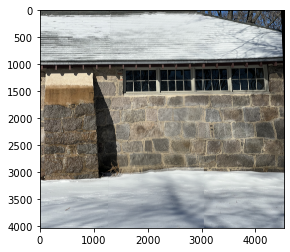

In [261]:
pt1=[]
pt2=[]
for pt in im2_to_3["im3"]:
    pt1.append([pt.x,pt.y])
for pt in im2_to_3["im2"]:
    pt2.append([pt.x,pt.y])
H=getH(pt1,pt2)

(im32,H32,H32_trans)=imgWarp(images[1],images[2],H)


/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


(12532, 4032)


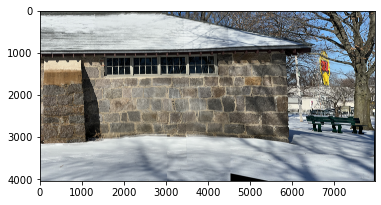

In [262]:
pt1=[]
pt2=[]
for pt in im1_to_2["im2"]:
    pt1.append([pt.x,pt.y])
for pt in im1_to_2["im1"]:
    pt2.append([pt.x,pt.y])
H=getH(pt1,pt2)
H=np.matmul(H32,H)
(im321,H321,H321_trans)=imgWarp(images[0],im32,H)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


(11363, 4032)


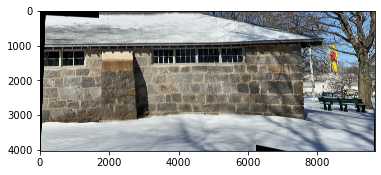

In [263]:
pt1=[]
pt2=[]
for pt in im3_to_4["im3"]:
    pt1.append([pt.x,pt.y])
for pt in im3_to_4["im4"]:
    pt2.append([pt.x,pt.y])
H34=getH(pt1,pt2)
# H=np.matmul(H321,H)
(im4321,H4321,H4321_trans)=imgWarp(images[3],im321,H34)

/var/folders/xh/b9gkq_p12x95yb6qg4603lq40000gn/T/ipykernel_2960/3460832648.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H, residuals, rank, s = np.linalg.lstsq(p,x)


(13149, 4032)


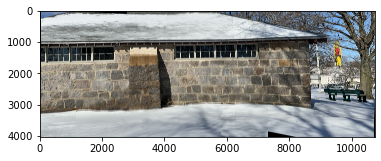

In [264]:
pt1=[]
pt2=[]
for pt in im4_to_5["im4"]:
    pt1.append([pt.x,pt.y])
for pt in im4_to_5["im5"]:
    pt2.append([pt.x,pt.y])
H=getH(pt1,pt2)
H=np.matmul(H34,H)
H=np.matmul(H4321_trans,H)
(im54321,H54321,H54321_trans)=imgWarp(images[4],im4321,H)

and Done! I think this came out pretty nice =D

### Bonus paper discussion

Lets compare the blending method discussed here: http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf
versus our method.

This paper discusses alpha blending but over a specified transition window where ours is constant. By this, if you have two images, img1 and img2, a1 and a1 (alpha 1 and 2) will be applied over a specified overlap point and ascend/descend linearly to each other.

This method provides a much cleaner blend with the correct window as it will remove overlap seams and ghosting in the blend region. Our method, in comparison, just provides a simple 50/50 blend that, while helping to soften image transitions, exhibits some blurring at spots.